# HarvestStat Data Analysis - Angola

## Issue 1: Potential duplicates

In [10]:
import json, requests
import pandas as pd
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Angola',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df[
    (df['admin_1'] == 'Bengo') &
    (df['product'] == 'Maize (Corn)')
].pivot_table(index='season_date', columns=['crop_production_system','indicator'],values='value')

crop_production_system     All (PS)                         Commercial (PS)  \
indicator              Area Planted Quantity Produced Yield  Area Harvested   
season_date                                                                   
1997-02-28                  11000.0            6710.0  0.61             NaN   
1998-02-28                  14000.0            9800.0  0.70             NaN   
1999-02-28                      NaN               NaN   NaN             NaN   
2000-02-29                  10002.0           12002.0  1.20             NaN   
2001-02-28                      NaN               NaN   NaN             NaN   
2002-02-28                      NaN               NaN   NaN             NaN   
2003-02-28                      NaN               NaN   NaN             NaN   
2004-02-29                      NaN               NaN   NaN             NaN   
2005-02-28                      NaN               NaN   NaN             NaN   
2006-02-28                      NaN               NaN   NaN             NaN   
2007-02-28                      NaN               NaN   NaN             NaN   
2008-02-29                      NaN               NaN   NaN             NaN   
2009-02-28                      NaN               NaN   NaN             NaN   
2010-02-28                      NaN               NaN   NaN             NaN   
2011-02-28                      NaN               NaN   NaN             NaN   
2012-02-29                      NaN               NaN   NaN             NaN   
2013-02-28                      NaN               NaN   NaN             NaN   
2014-02-28                      NaN               NaN   NaN             NaN   
2015-02-28                      NaN               NaN   NaN         21607.0   
2016-02-29                      NaN               NaN   NaN         21607.0   
2017-02-28                      NaN               NaN   NaN         29506.4   

crop_production_system                                      Small-scale (PS)  \
indicator              Area Planted Quantity Produced Yield   Area Harvested   
season_date                                                                    
1997-02-28                      NaN               NaN   NaN              NaN   
1998-02-28                      NaN               NaN   NaN              NaN   
1999-02-28                      NaN               NaN   NaN              NaN   
2000-02-29                      NaN               NaN   NaN              NaN   
2001-02-28                      NaN               NaN   NaN           6050.0   
2002-02-28                      NaN               NaN   NaN           5881.0   
2003-02-28                      NaN               NaN   NaN           7427.0   
2004-02-29                      NaN               NaN   NaN          10821.0   
2005-02-28                      NaN               NaN   NaN           7358.0   
2006-02-28                      NaN               NaN   NaN           7422.0   
2007-02-28                    387.0             851.0  2.20              NaN   
2008-02-29                    275.0             715.0  2.60              NaN   
2009-02-28                    274.0             521.0  1.90              NaN   
2010-02-28                      NaN               NaN   NaN          15974.0   
2011-02-28                      NaN               NaN   NaN          18421.0   
2012-02-29                      NaN               NaN   NaN           9614.0   
2013-02-28                      NaN               NaN   NaN          19741.0   
2014-02-28                      NaN               NaN   NaN          19790.0   
2015-02-28                  24618.0            4929.0  0.20          21607.0   
2016-02-29                  24618.0            4929.0  0.20          21607.0   
2017-02-28                  29865.8           17633.0  0.59          29506.4   

crop_production_system                                       
indicator              Area Planted Quantity Produced Yield  
season_date                                               

## Validation with FAOSTAT and CHIRPS Precipitation

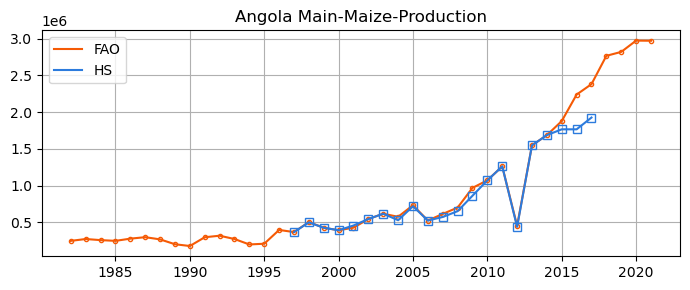

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Crop Data ------------------------------------- #
country_name, season_name, product_name_fdw, product_name_fao,  = 'Angola', 'Main', 'Maize', 'Maize (corn)'
shape_code, prcp_start_month, prcp_season_name, prcp_year_offset = 'AO2008A0', 10, 'OND PRCP (mm)', +1
# HarvestStat
df = pd.read_csv('../public/hvstat_data.csv', index_col=0)
df = df[
    (df['country'] == country_name) &
    (df['season_name'] == season_name) &
    (df['product'].isin([product_name_fdw])) &
    (df['indicator'] == 'production')
].copy()
df['year'] = df['harvest_year']
data_hs = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').squeeze()
# FAO-STAT
df = pd.read_csv('../data/crop/adm_fao_stat.csv', index_col=0)
data_fao = df[
    (df['Area'] == country_name) &
    (df['Item'] == product_name_fao) &
    (df['Element'] == 'Production')
].set_index('Year')['Value']
# Merge
data = pd.concat([data_fao,data_hs], axis=1, keys=['FAO','HS']).sort_index()
data = data.reindex(np.array(range(1982,2024)))
# ---------------------------------------------------- #
# Load precipitation --------------------------------- #
#fn = '../data/prcp_chirps-v2.hdf'
#prcp_nat = pd.read_hdf(fn)[shape_code].resample('1M').agg('sum')
#prcp_nat.index = prcp_nat.index.map(lambda x: x.replace(day=1))
#prcp_nat.name = 'PRCP'
#prcp_nat.index = prcp_nat.index + pd.DateOffset(years=prcp_year_offset)
# Forward rolling summation
#indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)   # Forward Rolling Window
#prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
#prcp_nat = prcp_nat[prcp_nat.index.month == prcp_start_month]                      # Start month
#prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
#prcp_label = prcp_season_name
# Correlations
#corr_value = pd.concat([data,prcp_nat],axis=1).corr()
#print(f'{season_name}-{product_name_fdw} Correlation:\n{corr_value}')
# ---------------------------------------------------- #
# Comparison with Precipitation ---------------------- #
fig, ax1 = plt.subplots(figsize=(7,3))
fig.set_facecolor('white')
data.plot(ax=ax1, grid=True, markerfacecolor='None',color=['#F55A05','#2C7BDD'])
marker = ['.','s']
for i, line in enumerate(ax1.get_lines()):
    line.set_marker(marker[i])
# years = data.index
# ax1.set_xticks(years)
# ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
#ax1.set_xlim([data.index[0]-0.5, data.index[-1]+0.5])
#ax1.set_xlabel('Year')
#ax1.set_ylabel('National Maize Production (ton)')
#ax1.patch.set_facecolor('white')
# Precipitation
#year, value = prcp_nat.index, prcp_nat.values
#ax2 = ax1.twinx()
#plt.bar(year, value, alpha=.25, color='grey')
#ax2.set_ylim([0, value.max()*1.3])
#ax2.set_ylabel(prcp_label + ' (year+%d)'%prcp_year_offset, labelpad=10)
#ax2.grid(False)
#ax1.set_zorder(1)  
#ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
#ax1.legend(loc='upper left')
#ax1.annotate(
#    'R: %.3f (HS)\nR: %.3f (FAO)' % (corr_value.loc['HS','PRCP'], corr_value.loc['FAO','PRCP']), 
#    xy=(1, 0.2), xycoords='axes fraction', fontsize=10,
#    xytext=(-5, -5), textcoords='offset points',
#    ha='right', va='top'
#)
title = f'{country_name} {season_name}-{product_name_fdw}-Production'# and {prcp_label}'
ax1.set_title(title)
fig.tight_layout()
plt.show()
# ---------------------------------------------------- #

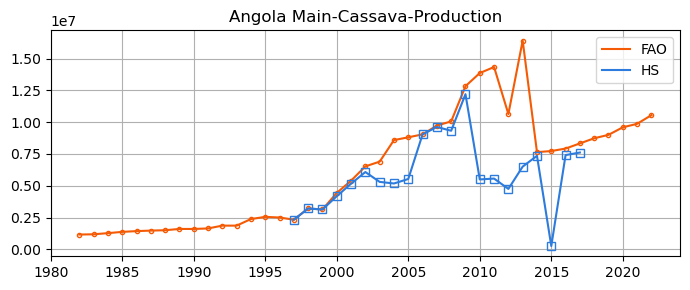

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Crop Data ------------------------------------- #
country_name, season_name, product_name_fdw, product_name_fao,  = 'Angola', 'Main', 'Cassava', 'Cassava, fresh'
shape_code, prcp_start_month, prcp_season_name, prcp_year_offset = 'AO2008A0', 10, 'OND PRCP (mm)', +1
# HarvestStat
df = pd.read_csv('../public/hvstat_data.csv', index_col=0)
df = df[
    (df['country'] == country_name) &
    (df['season_name'] == season_name) &
    (df['product'].isin([product_name_fdw])) &
    (df['indicator'] == 'production')
].copy()
df['year'] = df['harvest_year']
data_hs = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').squeeze()
# FAO-STAT
df = pd.read_csv('../data/crop/FAO_cassava.csv', index_col=0)
data_fao = df[
    (df['Area'] == country_name) &
    (df['Item'] == product_name_fao) &
    (df['Element'] == 'Production')
].set_index('Year')['Value']
# Merge
data = pd.concat([data_fao,data_hs], axis=1, keys=['FAO','HS']).sort_index()
data = data.reindex(np.array(range(1982,2024)))
# ---------------------------------------------------- #
fig, ax1 = plt.subplots(figsize=(7,3))
fig.set_facecolor('white')
data.plot(ax=ax1, grid=True, markerfacecolor='None',color=['#F55A05','#2C7BDD'])
marker = ['.','s']
for i, line in enumerate(ax1.get_lines()):
    line.set_marker(marker[i])
title = f'{country_name} {season_name}-{product_name_fdw}-Production'# and {prcp_label}'
ax1.set_title(title)
fig.tight_layout()
plt.show()
# ---------------------------------------------------- #


array(['Cassava, fresh'], dtype=object)